In [17]:
# =============================================================
# Week 2 — Climate Risk & Disaster Management
# EDA · Data Transformation · Feature Selection
# =============================================================

# 0) Imports & display options
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

# preprocessing & feature selection
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

# utilities
from pathlib import Path
import seaborn as sns  # only for nicer heatmap layout (optional)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

RANDOM_STATE = 42
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)


Pandas: 2.2.2
Numpy: 2.0.2


In [18]:
# 1) Load dataset (update filename if necessary)
DATA_PATH = "/content/climate-risk-index-1.csv"
path = Path(DATA_PATH)
if not path.exists():
    raise FileNotFoundError(f"File not found: {path.resolve()}")

df = pd.read_csv(path, low_memory=False)
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (182, 17)


,index,cartodb_id,the_geom,the_geom_webmercator,country,cri_rank,cri_score,fatalities_per_100k_rank,fatalities_per_100k_total,fatalities_rank,fatalities_total,losses_per_gdp__rank,losses_per_gdp__total,losses_usdm_ppp_rank,losses_usdm_ppp_total,rw_country_code,rw_country_name
0,0,1,NaN,NaN,Saudi Arabia,79,72.50,18,0.45,18,140,131,0.0001,119,1.229,SAU,Saudi Arabia
1,1,2,NaN,NaN,Romania,61,61.50,112,0.01,102,1,16,0.6746,11,2797.884,ROU,Romania
2,2,3,NaN,NaN,Spain,69,66.33,74,0.05,47,22,86,0.0394,31,637.070,ESP,Spain
3,3,4,NaN,NaN,Slovenia,135,124.50,114,0.00,114,0,135,NaN,135,0.000,SVN,Slovenia
4,4,5,NaN,NaN,South Sudan,133,117.33,114,0.00,114,0,120,0.0021,122,0.508,SSD,South Sudan


In [19]:
# 2) Quick structural checks (Week 1 continuation)
display(df.info())
display(df.describe(include='all'))
display(df.isnull().sum().sort_values(ascending=False))
print("Duplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      182 non-null    int64  
 1   cartodb_id                 182 non-null    int64  
 2   the_geom                   0 non-null      float64
 3   the_geom_webmercator       0 non-null      float64
 4   country                    182 non-null    object 
 5   cri_rank                   182 non-null    int64  
 6   cri_score                  182 non-null    float64
 7   fatalities_per_100k_rank   182 non-null    int64  
 8   fatalities_per_100k_total  182 non-null    float64
 9   fatalities_rank            182 non-null    int64  
 10  fatalities_total           182 non-null    int64  
 11  losses_per_gdp__rank       182 non-null    int64  
 12  losses_per_gdp__total      131 non-null    float64
 13  losses_usdm_ppp_rank       182 non-null    int64  

None

,index,cartodb_id,the_geom,the_geom_webmercator,country,cri_rank,cri_score,fatalities_per_100k_rank,fatalities_per_100k_total,fatalities_rank,fatalities_total,losses_per_gdp__rank,losses_per_gdp__total,losses_usdm_ppp_rank,losses_usdm_ppp_total,rw_country_code,rw_country_name
count,182.000000,182.000000,0.0,0.0,182,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,131.000000,182.000000,182.000000,179,179
unique,NaN,NaN,NaN,NaN,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179,179
top,NaN,NaN,NaN,NaN,Saudi Arabia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAU,Saudi Arabia
freq,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
mean,90.500000,91.500000,NaN,NaN,NaN,85.230769,81.791923,78.609890,0.519670,77.626374,86.840659,85.302198,1.517654,85.302198,907.507599,NaN,NaN
std,52.683014,52.683014,NaN,NaN,NaN,44.708529,34.582412,37.858511,3.393934,37.500688,427.350623,44.691600,8.171267,44.691600,4483.998505,NaN,NaN
min,0.000000,1.000000,NaN,NaN,NaN,1.000000,12.170000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000100,1.000000,0.000000,NaN,NaN
25%,45.250000,46.250000,NaN,NaN,NaN,46.250000,52.872500,46.250000,0.000000,46.250000,0.000000,46.250000,0.016500,46.250000,0.000000,NaN,NaN
50%,90.500000,91.500000,NaN,NaN,NaN,91.000000,77.500000,91.500000,0.020000,90.000000,2.000000,91.500000,0.084100,91.500000,30.347000,NaN,NaN
75%,135.750000,136.750000,NaN,NaN,NaN,135.000000,124.500000,114.000000,0.120000,114.000000,22.750000,135.000000,0.275950,135.000000,262.178250,NaN,NaN


,0
the_geom,182
the_geom_webmercator,182
losses_per_gdp__total,51
rw_country_code,3
rw_country_name,3
index,0
cri_rank,0
cartodb_id,0
country,0
fatalities_per_100k_total,0


Duplicate rows: 0


In [20]:
# 3) Clean column names (optional) — make them easier to reference
df.columns = [c.strip().lower().replace(" ", "_").replace("__", "_") for c in df.columns]
df.rename(columns={"rw_country_name":"country_name"}, inplace=True)
df.head(2)


,index,cartodb_id,the_geom,the_geom_webmercator,country,cri_rank,cri_score,fatalities_per_100k_rank,fatalities_per_100k_total,fatalities_rank,fatalities_total,losses_per_gdp_rank,losses_per_gdp_total,losses_usdm_ppp_rank,losses_usdm_ppp_total,rw_country_code,country_name
0,0,1,NaN,NaN,Saudi Arabia,79,72.5,18,0.45,18,140,131,0.0001,119,1.229,SAU,Saudi Arabia
1,1,2,NaN,NaN,Romania,61,61.5,112,0.01,102,1,16,0.6746,11,2797.884,ROU,Romania


In [21]:
# 4) Convert obvious numeric columns to numeric (coerce errors to NaN)
num_cols_guess = [
    "cri_rank","cri_score","fatalities_per_100k_rank","fatalities_per_100k_total",
    "fatalities_rank","fatalities_total","losses_per_gdp__rank","losses_per_gdp__total",
    "losses_usdm_ppp_rank","losses_usdm_ppp_total"
]
num_cols = [c for c in num_cols_guess if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Show dtypes after conversion
df[num_cols].dtypes


,0
cri_rank,int64
cri_score,float64
fatalities_per_100k_rank,int64
fatalities_per_100k_total,float64
fatalities_rank,int64
fatalities_total,int64
losses_usdm_ppp_rank,int64
losses_usdm_ppp_total,float64


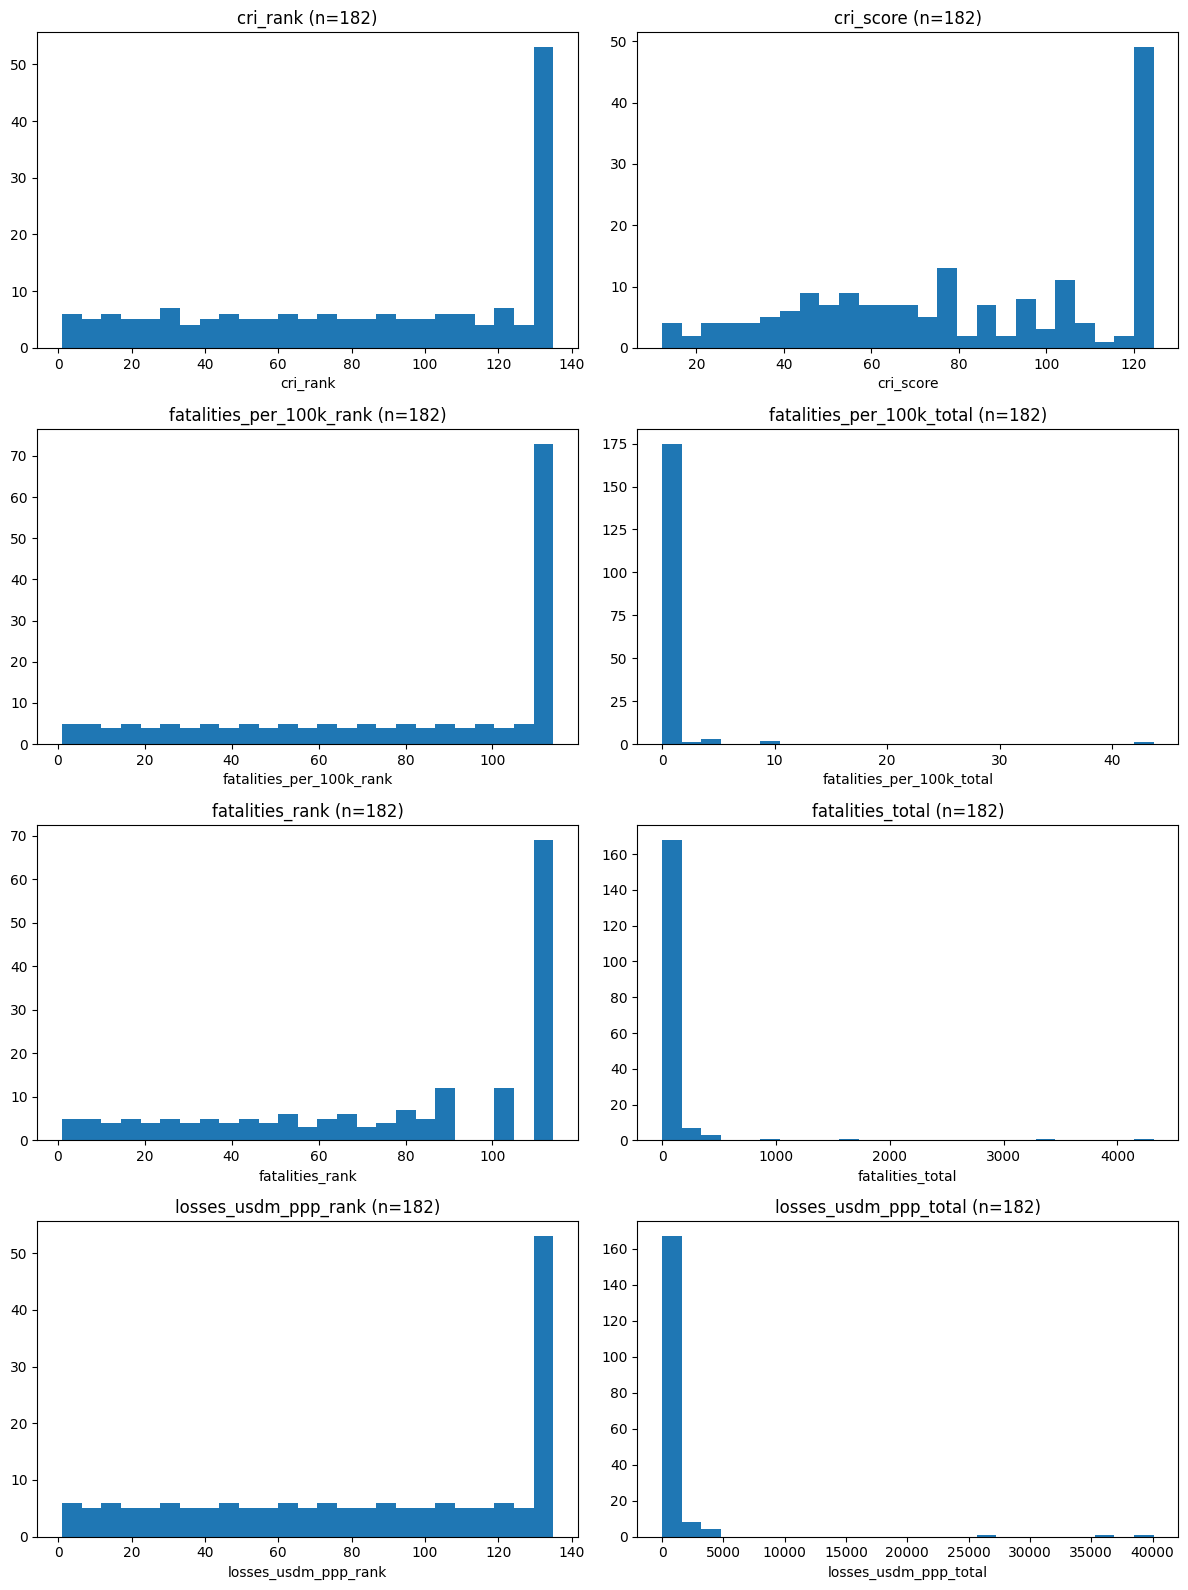

In [22]:
# 5) Univariate EDA: distributions for key numeric columns
plot_cols = [c for c in num_cols if c in df.columns][:8]  # first up to 8 columns
n = len(plot_cols)
rows = int(np.ceil(n/2))
plt.figure(figsize=(12, 4*rows))
for i, c in enumerate(plot_cols, 1):
    plt.subplot(rows, 2, i)
    plt.hist(df[c].dropna(), bins=25)
    plt.title(f"{c} (n={df[c].notna().sum()})")
    plt.xlabel(c)
plt.tight_layout()


In [23]:
# 6) Categorical overview: top categories for 'country' / 'country_name'
cat_cols = [c for c in ["country","country_name","rw_country_name","rw_country_code"] if c in df.columns]
for c in cat_cols:
    print(f"\n== {c} value counts (top 10) ==")
    try:
        print(df[c].value_counts(dropna=False).head(10))
    except Exception as e:
        print("Error:", e)



== country value counts (top 10) ==
country
Saudi Arabia       1
Romania            1
Spain              1
Slovenia           1
South Sudan        1
Sierra Leone       1
South Africa       1
Serbia             1
Slovak Republic    1
Solomon Islands    1
Name: count, dtype: int64

== country_name value counts (top 10) ==
country_name
NaN                   3
Saudi Arabia          1
Spain                 1
Romania               1
South Sudan           1
Sierra Leone          1
South Africa          1
Republic of Serbia    1
Slovakia              1
Solomon Islands       1
Name: count, dtype: int64

== rw_country_code value counts (top 10) ==
rw_country_code
NaN    3
SAU    1
ESP    1
ROU    1
SSD    1
SLE    1
ZAF    1
SRB    1
SVK    1
SLB    1
Name: count, dtype: int64


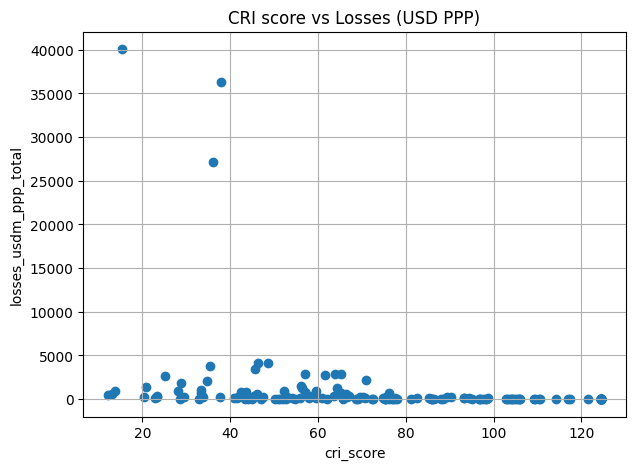

In [24]:
# 7) Bivariate analysis: scatter between cri_score and losses_usdm_ppp_total
if ("cri_score" in df.columns) and ("losses_usdm_ppp_total" in df.columns):
    plt.figure(figsize=(7,5))
    plt.scatter(df["cri_score"], df["losses_usdm_ppp_total"])
    plt.xlabel("cri_score")
    plt.ylabel("losses_usdm_ppp_total")
    plt.title("CRI score vs Losses (USD PPP)")
    plt.grid(True)


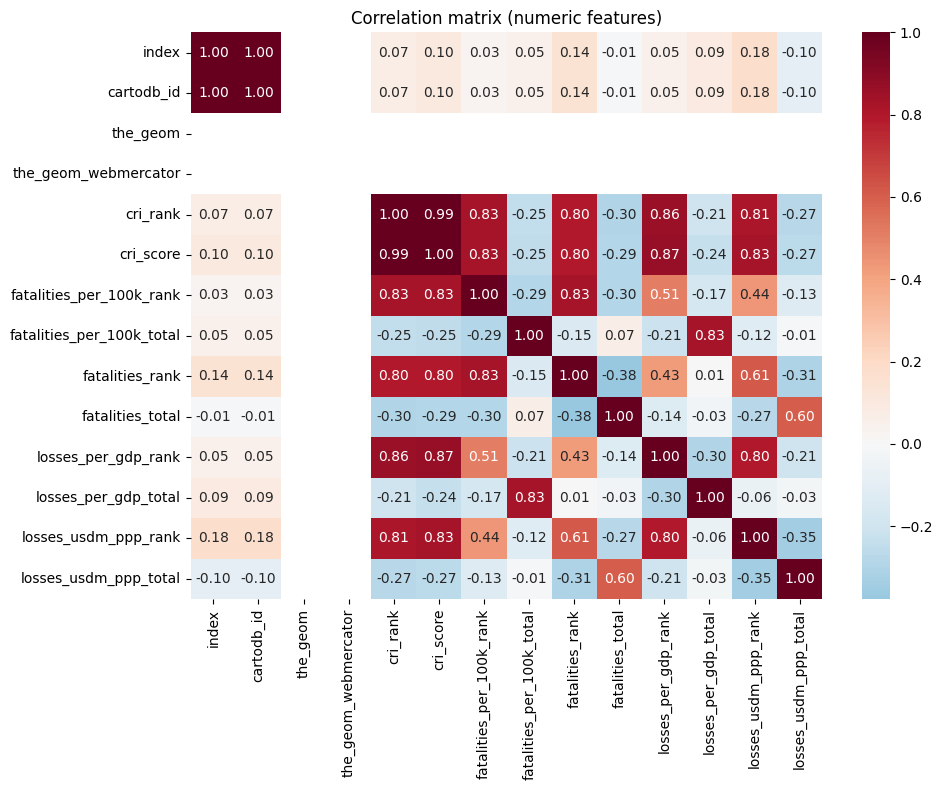

In [25]:
# 8) Correlation heatmap (numeric features)
numeric_df = df.select_dtypes(include=[np.number]).copy()
corr = numeric_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()


In [26]:
# 9) Missing value strategy
# Summarize missingness
missing = df.isnull().mean().sort_values(ascending=False)
display(missing.head(20))

# Strategy example:
# - For numeric columns with low missingness (<20%) -> median imputation
# - For numeric columns with high missingness (>50%) -> consider dropping or domain-specific imputation
# - For categorical -> fill with 'Unknown' or leave as NaN for OneHotEncoder handling


,0
the_geom,1.000000
the_geom_webmercator,1.000000
losses_per_gdp_total,0.280220
rw_country_code,0.016484
country_name,0.016484
index,0.000000
cri_rank,0.000000
cartodb_id,0.000000
country,0.000000
fatalities_per_100k_total,0.000000


In [27]:
# 10) Prepare data for feature selection
# Choose a target variable relevant for 'disaster management' analysis.
# Example targets: 'losses_usdm_ppp_total' or 'fatalities_total' or 'cri_score'
# Pick one for feature-selection demonstration:
TARGET = "losses_usdm_ppp_total"
if TARGET not in df.columns:
    raise ValueError(f"TARGET {TARGET} not in columns: {df.columns.tolist()}")

# Build feature matrix X and target y
X = df.drop(columns=[TARGET])
y = pd.to_numeric(df[TARGET], errors="coerce")

# Keep only numeric predictors for correlation and SelectKBest (later we'll demonstrate RF importance with encoded data)
X_num = X.select_dtypes(include=[np.number]).copy()
print("Numeric predictors shape:", X_num.shape)
print("Target non-null count:", y.notna().sum())


Numeric predictors shape: (182, 13)
Target non-null count: 182


In [30]:
# 11) Impute numeric predictors (median) and target rows removal if target null
from sklearn.impute import SimpleImputer
num_imp = SimpleImputer(strategy="median")

# Drop columns with all missing values before imputation
cols_to_drop = ['the_geom', 'the_geom_webmercator']
X_num_cleaned = X_num.drop(columns=cols_to_drop)

X_num_imputed = pd.DataFrame(num_imp.fit_transform(X_num_cleaned), columns=X_num_cleaned.columns, index=X_num_cleaned.index)

# Drop rows where target is null (cannot use those for supervised selection)
mask = y.notna()
X_sel = X_num_imputed.loc[mask]
y_sel = y.loc[mask].astype(float)
print("After dropping null-target rows:", X_sel.shape, y_sel.shape)

After dropping null-target rows: (182, 11) (182,)


In [31]:
# 12) Feature selection method A: correlation threshold
corr_with_target = X_sel.corrwith(y_sel).abs().sort_values(ascending=False)
display(corr_with_target.head(20))
# Keep features with absolute correlation > 0.2 (example threshold)
corr_threshold = 0.2
selected_by_corr = corr_with_target[corr_with_target > corr_threshold].index.tolist()
print("Selected by correlation (>|0.2|):", selected_by_corr)


,0
fatalities_total,0.602925
losses_usdm_ppp_rank,0.350230
fatalities_rank,0.309275
cri_rank,0.273320
cri_score,0.267235
losses_per_gdp_rank,0.208939
fatalities_per_100k_rank,0.125780
cartodb_id,0.096696
index,0.096696
losses_per_gdp_total,0.012970


Selected by correlation (>|0.2|): ['fatalities_total', 'losses_usdm_ppp_rank', 'fatalities_rank', 'cri_rank', 'cri_score', 'losses_per_gdp_rank']


In [32]:
# 13) Feature selection method B: univariate statistical test (SelectKBest)
k = min(10, X_sel.shape[1])  # pick up to 10 best features
skb = SelectKBest(score_func=f_regression, k=k)
skb.fit(X_sel.fillna(0), y_sel)  # f_regression requires finite values
skb_scores = pd.Series(skb.scores_, index=X_sel.columns).sort_values(ascending=False)
display(skb_scores.head(k))
selected_by_skb = skb_scores.head(k).index.tolist()
print("Selected by SelectKBest:", selected_by_skb)


,0
fatalities_total,102.805005
losses_usdm_ppp_rank,25.165935
fatalities_rank,19.038170
cri_rank,14.532348
cri_score,13.843247
losses_per_gdp_rank,8.216723
fatalities_per_100k_rank,2.893490
cartodb_id,1.698897
index,1.698897
losses_per_gdp_total,0.030285


Selected by SelectKBest: ['fatalities_total', 'losses_usdm_ppp_rank', 'fatalities_rank', 'cri_rank', 'cri_score', 'losses_per_gdp_rank', 'fatalities_per_100k_rank', 'cartodb_id', 'index', 'losses_per_gdp_total']


In [35]:
# 14) Feature selection method C: Random Forest feature importance (works with mixed data)
# Prepare a simple preprocessed dataset: numeric imputed + categorical one-hot (if needed)
# We'll use only a few categorical columns if they exist (like 'country' or 'rw_country_code')
categorical_cols = [c for c in ["country","country_name","rw_country_code"] if c in df.columns]
numeric_cols = X_num_cleaned.columns.tolist() # Use X_num_cleaned to avoid the geom columns

# Preprocessing pipeline
num_pipeline = ("num", SimpleImputer(strategy="median"), numeric_cols)
# For simple demonstration we will one-hot encode top N categories for country to avoid explosion
def top_k_onehot(df_col, k=10):
    top = df_col.value_counts().nlargest(k).index
    return pd.get_dummies(df_col.where(df_col.isin(top)).fillna("Other"), prefix=df_col.name)

# Build DF for RF
df_rf = X[numeric_cols].copy()
# Add top-k one-hot for a single categorical (if present)
if categorical_cols:
    cat = categorical_cols[0]
    df_rf = pd.concat([df_rf, top_k_onehot(X[cat], k=8)], axis=1)

# Impute numeric columns separately and then update
df_rf[numeric_cols] = num_imp.fit_transform(df_rf[numeric_cols])


# Align with target rows (drop rows where y is null)
df_rf = df_rf.loc[mask]
y_rf = y_sel

print("RF input shape:", df_rf.shape)
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(df_rf, y_rf)
feat_importances = pd.Series(rf.feature_importances_, index=df_rf.columns).sort_values(ascending=False)
display(feat_importances.head(20))
selected_by_rf = feat_importances.head(10).index.tolist()
print("Top features by RandomForest:", selected_by_rf)

RF input shape: (182, 20)


,0
losses_usdm_ppp_rank,9.162796e-01
fatalities_rank,3.925666e-02
fatalities_total,3.496932e-02
losses_per_gdp_rank,2.797985e-03
losses_per_gdp_total,1.346745e-03
cartodb_id,1.289882e-03
fatalities_per_100k_rank,1.062079e-03
index,9.961268e-04
cri_score,8.747668e-04
cri_rank,7.065669e-04


Top features by RandomForest: ['losses_usdm_ppp_rank', 'fatalities_rank', 'fatalities_total', 'losses_per_gdp_rank', 'losses_per_gdp_total', 'cartodb_id', 'fatalities_per_100k_rank', 'index', 'cri_score', 'cri_rank']


In [36]:
# 15) Consolidate selected features (union of methods) and save list
selected_union = list(pd.Index(selected_by_corr).union(selected_by_skb).union(selected_by_rf))
print("Union of selected features (count={}):".format(len(selected_union)))
print(selected_union)

# Save selected feature names for later modeling
pd.Series(selected_union, name="selected_features").to_csv("selected_features_week2.csv", index=False)
print("Saved selected_features_week2.csv")


Union of selected features (count=10):
['cartodb_id', 'cri_rank', 'cri_score', 'fatalities_per_100k_rank', 'fatalities_rank', 'fatalities_total', 'index', 'losses_per_gdp_rank', 'losses_per_gdp_total', 'losses_usdm_ppp_rank']
Saved selected_features_week2.csv


In [37]:
# 16) Create and save a cleaned dataset with selected features + target
cleaned = pd.concat([df_rf[selected_union].reset_index(drop=True), y_rf.reset_index(drop=True)], axis=1)
cleaned.to_csv("cleaned_week2_selected_features.csv", index=False)
print("Saved cleaned_week2_selected_features.csv with shape:", cleaned.shape)


Saved cleaned_week2_selected_features.csv with shape: (182, 11)


In [38]:
# 17) Short summary (printable) — paste this into your LMS submission or README
print("WEEK 2 SUMMARY")
print("--------------")
print(f"Original shape: {df.shape}")
print(f"After dropping null-target rows: {X_sel.shape[0]}")
print(f"Selected features (example count): {len(selected_union)}")
print("Files saved: selected_features_week2.csv, cleaned_week2_selected_features.csv")


WEEK 2 SUMMARY
--------------
Original shape: (182, 17)
After dropping null-target rows: 182
Selected features (example count): 10
Files saved: selected_features_week2.csv, cleaned_week2_selected_features.csv
